In [2]:
import numpy as np
# import librosa

import matlab
import matlab.engine

from IPython.display import Audio 

%matplotlib inline
import matplotlib.pyplot as plt

import scattering

##### Load signal

In [3]:
# signal_path = "/home/julia/DeepVoice_data/samples/clear.wav"
# signal_wav, sr = librosa.load(signal_path)

# print(sr)
# Audio(signal_wav, rate = sr)

##### Create batch of signals and count scattering coefficients using matlab scattering implementation

function get_scattering_coefficients() from custom module scattering.py is used

In [5]:
N = 73112
T = 4096
np_arr_batch = np.random.normal(size = (2, N))

# np_arr_batch = np.array([signal_wav[:40000]]*2)
# N = np_arr_batch.shape[1]
# T = 1024


path_to_scatnet = '/workspace/jgusak/Matlab_pkgs/scatnet-master/'
S_table_batch, time_count, coeffs_count = scattering.get_scattering_coefficients(path_to_scatnet,
                                                                     np_arr_batch, N, T,
                                                                     M = 2, Q = [8,1],
                                                                     renorm = True,
                                                                     log = True)

print(S_table_batch.shape, S_table_batch[0].shape)
print(time_count, coeffs_count)

(2, 354, 36) (354, 36)
36 [1.0, 68.0, 285.0]


##### Visualize scattering coefficients of all orders as well as of each order separately

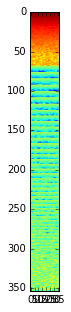

(354, 36)


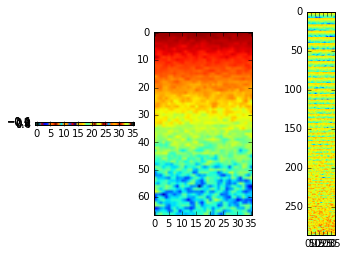

In [6]:
plt.figure(figsize = (10,5))
plt.imshow(S_table_batch[0])
plt.show()

print(S_table_batch[0].shape)
_, axs = plt.subplots(1, 3)
axs[0].imshow(S_table_batch[0][:1, :])
axs[1].imshow(S_table_batch[0][1:int(coeffs_count[1]), :])
axs[2].imshow(S_table_batch[0][int(coeffs_count[1]):, :])
plt.show()

# Playground

some examples that show how to use matlab implementation of scattering

In [2]:
# run matlab engine
eng = matlab.engine.start_matlab()

# add path to matlab scattering implementation
path_to_scatnet = '/home/julia/Downloads/scatnet-master/'
eng.eval("addpath {}; addpath_scatnet;".format(path_to_scatnet), nargout = 0)

In [3]:
# load signal from matlab library and set scattering parameters
eng.eval("load handel; N = length(y);", nargout = 0)
eng.eval("T = 2^12;", nargout = 0)
# eng.eval("filt_opt = default_filter_options('audio', T);", nargout = 0)
eng.eval("filt_opt.Q = {};".format(str([8, 1])), nargout = 0)
eng.eval("filt_opt.J = T_to_J(T, filt_opt);", nargout = 0)

# create filter bank
eng.eval("[Wop, filters] = wavelet_factory_1d(N, filt_opt)", nargout = 0)

# count scattering coefficients using filter bank, normalize and take logarithm (if needed)
eng.eval('S = scat(y, Wop);', nargout = 0)
eng.eval("S = renorm_scat(S);", nargout = 0)
eng.eval("S = log_scat(S);", nargout = 0)

# copy matlab variable to python variable
S = eng.eval('S;')

# collect all scattering coefficients in one table
eng.eval("[S_table, meta] = format_scat(S);", nargout = 0)

S_table = eng.eval('S_table;')

In [29]:
print(eng.eval('size(S_table);'))

for i in range(3):
    print(np.asarray(S[i]['signal']).shape,
          np.asarray(S[i]['meta']['j']).shape,
          np.asarray(S[i]['meta']['bandwidth']).shape,
          np.asarray(S[i]['meta']['resolution']).shape)

[[354.0,36.0]]
(1, 36, 1) (0,) () ()
(68, 36, 1) (1, 68) (1, 68) (1, 68)
(285, 36, 1) (2, 285) (1, 285) (1, 285)


In [30]:
eng.eval('filt_opt')['J'], eng.eval('filt_opt')['Q']

(matlab.double([[57.0,12.0]]), matlab.double([[8.0,1.0]]))

In [9]:
# count number of scatttering coefficients of each order
coeffs_count = []
for i in range(1,4):

    coeffs_shape_i = np.array(S[i-1]['signal']).shape
    coeffs_count_i = eng.eval("size(S{}.signal, 2);".format('{'+str(i)+'}'))
    time_count_i = eng.eval("size(S{}.signal{}, 1);".format('{'+str(i)+'}','{'+str(1)+'}'))
    
    coeffs_count.append(coeffs_count_i)

    print('Order {}:'.format(i), coeffs_shape_i, coeffs_count_i, time_count_i)

print(coeffs_count, '\t', sum(coeffs_count), 'coefficients in total')

print('\n Scattering table shape: {}'.format(np.array(S_table).shape))

Order 1: (1, 36, 1) 1.0 36.0
Order 2: (68, 36, 1) 68.0 36.0
Order 3: (285, 36, 1) 285.0 36.0
[1.0, 68.0, 285.0] 	 354.0 coefficients in total

 Scattering table shape: (354, 36)


##### Inverse scattering

not very fast, actually I haven't run nice experiments with it yet

In [31]:
# can take couple of minutes
eng.eval("[xt, Ut] = inverse_scat(S, filters);", nargout = 0)

In [32]:
xt = eng.eval('xt;')
y = eng.eval('y;')

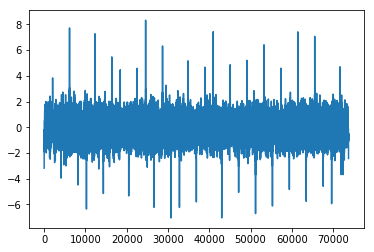

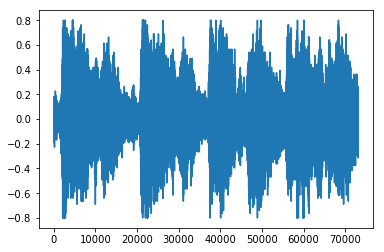

In [33]:
import IPython.display as ipd
import matplotlib.pylab as plt
% matplotlib inline

plt.plot(xt)
plt.show()

plt.plot(y)
plt.show()

In [34]:
ipd.Audio(np.asarray(y).ravel(), rate = 8000)

In [35]:
ipd.Audio(np.asarray(xt).ravel(), rate = 8000)